# Imports

In [231]:
import numpy as np
import matplotlib.pyplot as plt
import openpyxl
import pandas as pd 
import os

In [232]:
def calculate_migration_timestep(D_P, c_t, P_density, K_PF, t_step, V_P, V_F, d_P, d_F, A_PF):
    alpha = (1 / K_PF) * (V_F / V_P)
    upper_alpha = 10

    def calculate_q_n(n, alpha):
        if alpha < 0.1:
            return n * np.pi / (1 + alpha)
        elif alpha > upper_alpha:
            return (2 * n - 1) * np.pi / 2
        else:
            return (n - (alpha / (2 * (1 + alpha)))) * np.pi

    sum_a = 0
    k = 1
    while True:
        q_n = calculate_q_n(k, alpha)
        if alpha > upper_alpha:
            sum_term_i = (2 / q_n**2) * np.exp(-q_n**2 * (D_P / d_P**2) * t_step)
        else:
            sum_term_i = (2 * alpha * (1 + alpha)) / (1 + alpha + alpha**2 * q_n**2) * np.exp(-q_n**2 * (D_P / d_P**2) * t_step)

        sum_before = sum_a
        sum_a += sum_term_i

        # Terminierung der unendlichen Summe
        if abs(sum_a - sum_before) < 1e-6:
            break
        k += 1

    # Berechnet Migrationsmenge zu dem Zeitpunkt t_step und Fallunterscheidung abhängig von alpha
    if alpha > upper_alpha:
        migration_amount = c_t * P_density * d_P * (1 - sum_a)
    else:
        migration_amount = c_t * P_density * d_P * (alpha / (1 + alpha)) * (1 - sum_a)

    # Verhindert negative Konzentrationen
    if migration_amount < 0:
        migration_amount = 0

    return migration_amount

def migrationsmodell_piringer_for_curve_fitting(c_P0, P_density, K_PF, t_max, V_P, V_F, d_P, d_F, A_PF, dt, D_P_known):

    D_P = D_P_known

    migration_data = []
    current_time = 0

    while current_time <= t_max:
        migration_amount = calculate_migration_timestep(D_P, c_P0, P_density, K_PF, current_time, V_P, V_F, d_P, d_F, A_PF)
        migration_data.append(migration_amount)
        current_time += dt
        
    migration_data = (np.array(migration_data) - migration_data[0]) / 10  # Umrechnung in [mg/dm²]

    return migration_data

def plot_results_area(results, t_max, dt, save_path=None): 
    # Plot the area-specific migration results
    plt.figure(figsize=(10, 6))
    time_days = np.arange(0, t_max / (3600 * 24), dt / (3600 * 24))
    plt.plot(time_days, results, linewidth = 2, color = '#F06D1D')
    
    # Plot speichern, wenn ein Pfad angegeben wurde
    if save_path:
        plot_filename = os.path.join(save_path, 'migrated_mass_plot.pdf')
        plt.savefig(plot_filename, bbox_inches='tight')
        print(f"Migrationsplot gespeichert unter: {plot_filename}")
              
    # Achsenbeschriftungen und Titel
    plt.xlabel('Zeit $[Tage]$', fontsize=14)
    plt.ylabel('spez. Migrationsmenge $[mg/dm^2]$', fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

def error_function(D_P_candidate, c_P0, P_density, K_PF, t_max, V_P, V_F, d_P, d_F, A_PF, dt, measured_values, measurement_days):
    simulation_result = migrationsmodell_piringer_for_curve_fitting(c_P0, P_density, K_PF, t_max, V_P, V_F, d_P, d_F, A_PF, dt, D_P_candidate)
    
    # Indizes: Messzeit in Tagen - 1 (z. B. Tag 7 -> Index 6)
    indices = [day - 1 for day in measurement_days]
    
    sim_values = simulation_result[indices]
    
    error = np.sum((sim_values - measured_values)**2)
    return error

def save_results_to_excel(measurement_point, optimal_D_P, excel_path):
    """Speichert Messdaten & berechneten Diffusionskoeffizienten in Excel.
    Falls die Datei noch nicht existiert, wird sie initialisiert.
    Vermeidet doppelte Einträge basierend auf Surrogate & Temperatur.
    """

    # Basisdaten für den Messpunkt (ohne Messwerte und Zeitpunkte)
    base_data = {
        "Surrogate": measurement_point["surrogate"],
        "Temperatur [°C]": measurement_point["temperature_C"],
        "c_P0 [mg/kg]": measurement_point["c_P0"],
        "D_calc [cm²/s]": optimal_D_P
    }

    # In DataFrame umwandeln
    new_entry = pd.DataFrame([base_data])

    # Falls Datei existiert, lade sie und prüfe auf Duplikate
    if os.path.exists(excel_path):
        try:
            existing_df = pd.read_excel(excel_path)

            # Falls die Datei existiert, aber leer ist, initialisieren wir sie mit den richtigen Spalten
            if existing_df.empty:
                print("Excel-Datei existiert, aber ist leer. Sie wird neu initialisiert.")
                existing_df = pd.DataFrame(columns=new_entry.columns)

        except Exception as e:
            print(f"Fehler beim Laden der Datei: {e}. Datei wird neu erstellt.")
            existing_df = pd.DataFrame(columns=new_entry.columns)

    else:
        # Falls Datei nicht existiert, erzeuge leere Datei mit korrekten Überschriften
        existing_df = pd.DataFrame(columns=new_entry.columns)
        print("Neue Excel-Datei wird erstellt.")

    # Prüfe, ob der Messpunkt bereits existiert (Surrogate + Temperatur)
    duplicate_mask = (
        (existing_df["Surrogate"] == measurement_point["surrogate"]) &
        (existing_df["Temperatur [°C]"] == measurement_point["temperature_C"])
    )

    if duplicate_mask.any():
        print("Messpunkt existiert bereits. Kein doppelter Eintrag.")
        return

    # Falls kein Duplikat, neue Daten anhängen
    updated_df = pd.concat([existing_df, new_entry], ignore_index=True)

    # Speichern als Excel-Datei
    updated_df.to_excel(excel_path, index=False)
    print(f"Ergebnisse gespeichert unter: {excel_path}")


In [233]:
# Physikalisch-chemische Eigenschaften
# M_r = 136            # relative Molekülmasse des Migranten [g/mol]
# T_C = 20             # Temperatur [°C]
# Material = "PP"   # Material des Polymers [-]

# Speicherpfad der Excel-Datei
excel_path = "/Users/tomhartmann/Documents/GitHub/fdm-migration-calc/data/Ergebnisse_Diffcoeff_curve-fitting.xlsx"

# Geometrische Größen
A_PF = 0.2827             # Kontaktfläche Polymer/Fluid [dm^2] (MigraCell 60)
V_P = 10.6384    # Volumen des Polymers [cm^3] (von Andre)
V_F = 28.27    # Volumen des Fluids [cm^3] (von Andre)
d_P = V_P / (A_PF * 1e2)           # Durchmesser des Polymers [cm]
d_F = V_F / (A_PF * 1e2)            # Durchmesser des Fluids [cm]

# Messpunkt
measurement_point = {
    "surrogate": "Amberonne",        # Ersatzstoff (Surrogate)
    "temperature_C": 60,             # Temperatur in °C
    "c_P0": 661,           # Anfangskonzentration im Polymer [mg/kg]
    "time_days": np.array([7, 14, 28]),  # Zeitpunkte der Messungen in Tagen      
    "c_F": np.array([6.4, 10.2, 12.2])  # Konzentration in der Kontaktphase [mg/kg]
}

c_P0 = measurement_point["c_P0"]           # Anfangskonzentration im Polymer [mg/kg]
P_density = 0.9045   # Dichte des Polymers [g/cm^3]
F_density = 0.9      # Dichte des Fluids [g/cm^3]
K_PF = 1             # Verteilungskoeffizient [-]
dt = 3600 * 24           # 1 Tag in Sekunden
t_max = max(measurement_point["time_days"]) * dt      # 28 Tage in Sekunden


# Umrechnung von Einheiten
m_F = V_F * F_density * 1e-3  # Masse der Kontaktphase in [kg]
measured_values = (measurement_point["c_F"] / A_PF) * m_F # Messwerte der Konzentration Umrechnung in [mg/dm^2]
measurement_days = measurement_point["time_days"]

# Suchbereich der Diffusionskoeffizienten in logarithmischem Maßstab:
D_P_candidates = np.logspace(-12, -7, num=100)  # 100 Kandidatenwerte


In [234]:
errors = []
for D_P_candidate in D_P_candidates:
    err = error_function(D_P_candidate, c_P0, P_density, K_PF, t_max, V_P, V_F, d_P, d_F, A_PF, dt, measured_values, measurement_days)
    errors.append(err)

errors = np.array(errors)
min_error = np.min(errors)
optimal_index = np.argmin(errors)
optimal_D_P = D_P_candidates[optimal_index]
print("Optimierter Diffusionskoeffizient:", optimal_D_P, "cm²/s")

Optimierter Diffusionskoeffizient: 1.3219411484660286e-10 cm²/s


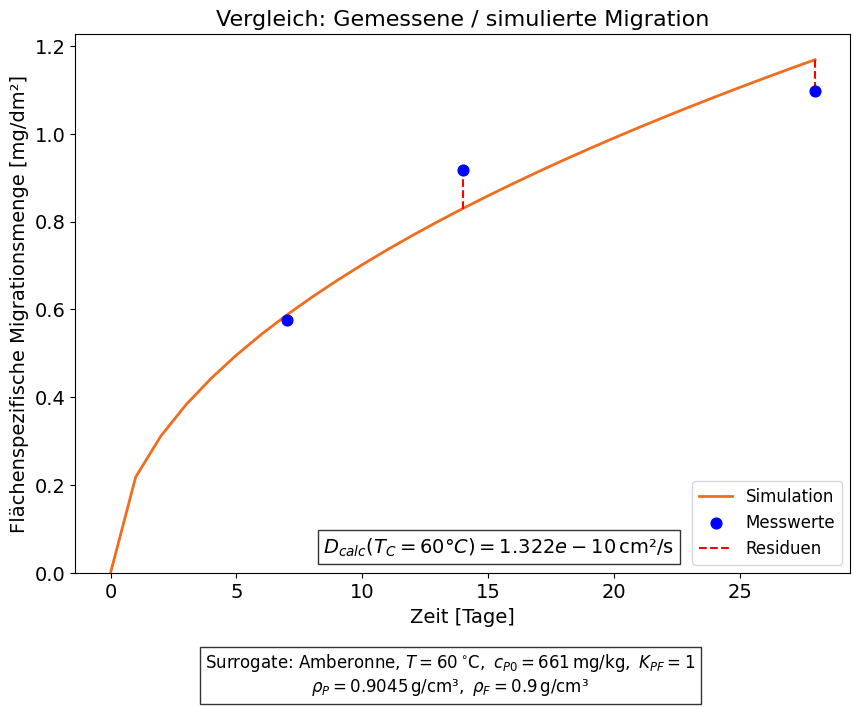

In [235]:
# Simulation mit dem optimierten Diffusionskoeffizienten
optimal_simulation = migrationsmodell_piringer_for_curve_fitting(c_P0, P_density, K_PF, t_max, V_P, V_F, d_P, d_F, A_PF, dt, optimal_D_P)

# Zeitachse in Tagen (da dt = 1 Tag in Sekunden)
time_days_full = np.arange(0, t_max / 86400 + 1, 1)  # 0, 1, 2, ..., 28 (+1, da stop excluded)

# Plot der gesamten berechneten Kurve
plt.figure(figsize=(10, 7))
plt.plot(time_days_full, optimal_simulation, label=f'Simulation', linewidth=2, color='#F06D1D')

# Overlay der Messwerte
plt.scatter(measurement_days, measured_values, label='Messwerte', color='blue', s=60, zorder=5)

# Berechnung der Residuen
indices = [np.argmin(np.abs(time_days_full - day)) for day in measurement_days]
simulated_at_measurement = optimal_simulation[indices]  # Simulierte Werte an den Messpunkten
residuals = measured_values - simulated_at_measurement  # Residuen

# Residuen als vertikale Linien anzeigen
for x, y_meas, y_sim in zip(measurement_days, measured_values, simulated_at_measurement):
    plt.vlines(x, y_sim, y_meas, color='red', linestyle='dashed', linewidth=1.5)

# Achsenbeschriftungen und Titel
plt.plot([], [], color='red', linestyle='dashed', linewidth=1.5, label="Residuen")  # Dummy für Residuen
plt.text(0.32, 0.037, rf"$D_{{calc}}(T_{{C}}={measurement_point["temperature_C"]}°C) = {optimal_D_P:.3e} \,\text{{cm²/s}}$", transform=plt.gca().transAxes, fontsize=14, bbox=dict(facecolor='white', alpha=0.8))
plt.xlabel('Zeit [Tage]', fontsize=14)
plt.ylabel('Flächenspezifische Migrationsmenge [mg/dm²]', fontsize=14)
plt.ylim(0)
plt.legend(fontsize=12, loc="lower right")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Vergleich: Gemessene / simulierte Migration", fontsize=16)

boundary_conditions = (
    rf"$\text{{Surrogate}}$: {measurement_point['surrogate']}, "
    rf"$T = {measurement_point['temperature_C']}\,^{{\circ}}\text{{C}},$ "
    rf"$c_{{P0}} = {c_P0}\,\text{{mg/kg}},$ "
    rf"$K_{{PF}} = {K_PF}$"
    "\n"
    rf"$\rho_P = {P_density}\,\text{{g/cm³}},$ "
    rf"$\rho_F = {F_density}\,\text{{g/cm³}}$"
)

plt.figtext(0.5, -0.06, boundary_conditions, ha="center", fontsize=12, bbox=dict(facecolor="white", alpha=0.8))

# Plot anzeigen
plt.show()

# Export in Excel-Datei

In [236]:
# Ergebnisse speichern
save_results_to_excel(measurement_point, optimal_D_P, excel_path)


Messpunkt existiert bereits. Kein doppelter Eintrag.
